# Autocorrelations

## Imports

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib notebook

from l2hmc_eager import gauge_dynamics_eager as gde

Using TensorFlow backend.


In [3]:
from lattice.gauge_lattice import GaugeLattice

In [4]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers

## Helper functions

In [82]:
def plot_multiple_lines(x_data, y_data, x_label, y_label, 
                        semilogy=False, legend=True, out_file=None):
    fig, ax = plt.subplots()
    plot_fn = ax.plot
    if semilogy:
        plot_fn = ax.semilogy
    for idx, row in enumerate(y_data):
        _ = plot_fn(x_data, row, ls='-', marker='', 
                    alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = plot_fn(x_data, y_data.mean(axis=0), marker='', ls='-', 
                color='k', lw=2., label='average')
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    if legend:
        ax.legend(loc='best')
    if out_file:
        print(f'Saving figure to {out_file}.')
        fig.savefig(out_file, dpi=400, bbox_inches='tight')
    return fig, ax

In [6]:
def autocovariance(X, tau=0):
  dT, dN, dX = np.shape(X)
  s = 0.
  for t in range(dT - tau):
    x1 = X[t, :, :]
    x2 = X[t+tau, :, :]

    s += np.sum(x1 * x2) / dN

  return s / (dT - tau)

def acl_spectrum(X, scale):
    n = X.shape[0]
    return np.array([autocovariance(X / scale, tau=t) for t in range(n-1)])

In [7]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result /= result[result.argmax()]
    return result[result.size//2:]

In [83]:
def plot_broken_xaxis(xdata, ydata, xlabel, ylabel, output_file=None,
                      xlim1=(-2, 100), xlim2=(398,  500)):
    fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
    # plot the same data on both axes
    for idx in range(ydata.shape[1]):
        _ = ax.plot(xdata, ydata[:, idx], marker='', ls='-', 
                    alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = ax.plot(xdata, ydata.mean(axis=1), marker='', ls='-', 
                color='k', lw=2., label='average')

    for idx in range(ydata.shape[1]):
        _ = ax2.plot(xdata, ydata[:, idx], marker='', ls='-', 
                     alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = ax2.plot(xdata, ydata.mean(axis=1), marker='', ls='-', 
                 color='k', lw=2., label='average')

    # zoom-in / limit the view to different portions of the data
    _ = ax.set_xlim(xlim1)
    _ = ax2.set_xlim(xlim2)

    # hide the spines between ax and ax2
    _ = ax.spines['right'].set_visible(False)
    _ = ax2.spines['left'].set_visible(False)
    _ = ax.yaxis.tick_left()
    _ = ax.tick_params(labelright=False)
    _ = ax2.yaxis.tick_right()

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    _ = ax.plot((1-d,1+d), (-d,+d), **kwargs)
    _ = ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    _ = kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    _ = ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    _ = ax2.plot((-d,+d), (-d,+d), **kwargs)

    _ = ax.set_ylabel(ylabel, fontsize=14)
    label = ax.set_xlabel(xlabel, fontsize=14)
    _ = ax.xaxis.set_label_coords(1.1, -0.065)
    _ = ax2.legend(loc='best', fontsize=10)

    _ = plt.show()
    if output_file is not None:
        fig.savefig(output_file, dpi=400, bbox_inches='tight')
    return fig, ax, ax2

## Specify run directory containing parameters and samples 

In [56]:
log_dir = '../../gauge_logs_graph/run_60/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [57]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [58]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [59]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

step: 0  time / step: 0.06631  avg action: 305.7   avg plaquette: 0.403  top charge: 0.03243
step: 1  time / step: 0.06678  avg action: 238.6   avg plaquette: 0.5339 top charge: -0.1294
step: 2  time / step: 0.06496  avg action: 177.4   avg plaquette: 0.6536 top charge: 0.1156
step: 3  time / step: 0.09004  avg action: 145.8   avg plaquette: 0.7152 top charge: -0.06462
step: 4  time / step: 0.09828  avg action: 124.6   avg plaquette: 0.7567 top charge: 0.03467
step: 5  time / step: 0.06935  avg action: 106.4   avg plaquette: 0.7922 top charge: -0.02773
step: 6  time / step: 0.07477  avg action: 97.73   avg plaquette: 0.8091 top charge: -0.07358
step: 7  time / step: 0.07298  avg action:  88.2   avg plaquette: 0.8277 top charge: 0.04554
step: 8  time / step: 0.1097  avg action: 86.22   avg plaquette: 0.8316 top charge: -0.02205
step: 9  time / step: 0.08674  avg action: 73.29   avg plaquette: 0.8569 top charge: 0.005358
step: 10  time / step: 0.08708  avg action: 71.29   avg plaquette: 

step: 88  time / step: 0.1691  avg action: 38.35   avg plaquette: 0.9251 top charge: -0.004751
step: 89  time / step: 0.1139  avg action: 39.44   avg plaquette: 0.923  top charge: 0.0271
step: 90  time / step: 0.1063  avg action: 40.17   avg plaquette: 0.9215 top charge: 0.01095
step: 91  time / step: 0.1186  avg action: 39.36   avg plaquette: 0.9231 top charge: -0.004374
step: 92  time / step: 0.1156  avg action:  41.2   avg plaquette: 0.9195 top charge: -0.0113
step: 93  time / step: 0.09828  avg action: 38.99   avg plaquette: 0.9239 top charge: -0.04563
step: 94  time / step: 0.08783  avg action: 38.79   avg plaquette: 0.9242 top charge: -0.02017
step: 95  time / step: 0.1193  avg action: 36.22   avg plaquette: 0.9293 top charge: -0.03899
step: 96  time / step: 0.08294  avg action: 38.88   avg plaquette: 0.9241 top charge: 0.05723
step: 97  time / step: 0.09157  avg action: 38.27   avg plaquette: 0.9253 top charge: 0.02033
step: 98  time / step: 0.1195  avg action: 36.21   avg plaqu

step: 176  time / step: 0.1791  avg action: 39.95   avg plaquette: 0.922  top charge: -0.03349
step: 177  time / step: 0.5486  avg action: 41.16   avg plaquette: 0.9196 top charge: 0.05875
step: 178  time / step: 0.1135  avg action: 39.89   avg plaquette: 0.9221 top charge: -0.02334
step: 179  time / step: 0.3095  avg action: 37.58   avg plaquette: 0.9266 top charge: -0.0241
step: 180  time / step: 0.1992  avg action: 37.28   avg plaquette: 0.9272 top charge: -0.03064
step: 181  time / step: 0.1179  avg action:  35.3   avg plaquette: 0.9311 top charge: -0.01673
step: 182  time / step: 0.1094  avg action: 34.51   avg plaquette: 0.9326 top charge: 0.0008073
step: 183  time / step: 0.09445  avg action: 34.39   avg plaquette: 0.9328 top charge: -0.03868
step: 184  time / step: 0.1057  avg action: 37.58   avg plaquette: 0.9266 top charge: -0.03219
step: 185  time / step: 0.2213  avg action: 32.78   avg plaquette: 0.936  top charge: -0.03907
step: 186  time / step: 0.3976  avg action: 38.05 

step: 265  time / step: 0.1168  avg action: 35.83   avg plaquette:  0.93  top charge: 0.04175
step: 266  time / step: 0.06862  avg action: 36.85   avg plaquette: 0.928  top charge: 0.0262
step: 267  time / step: 0.06097  avg action: 36.09   avg plaquette: 0.9295 top charge: -0.009532
step: 268  time / step: 0.05798  avg action: 34.11   avg plaquette: 0.9334 top charge: 0.0153
step: 269  time / step: 0.1055  avg action: 34.95   avg plaquette: 0.9317 top charge: -0.02395
step: 270  time / step: 0.0722  avg action: 33.92   avg plaquette: 0.9337 top charge: 0.01789
step: 271  time / step: 0.06656  avg action: 34.38   avg plaquette: 0.9328 top charge: -0.03231
step: 272  time / step: 0.06656  avg action:  35.8   avg plaquette: 0.9301 top charge: -0.01585
step: 273  time / step: 0.07619  avg action: 39.28   avg plaquette: 0.9233 top charge: -0.01149
step: 274  time / step: 0.05541  avg action: 38.16   avg plaquette: 0.9255 top charge: 0.002415
step: 275  time / step: 0.05544  avg action: 41.

step: 354  time / step: 0.08938  avg action: 36.89   avg plaquette: 0.9279 top charge: -0.008418
step: 355  time / step: 0.2771  avg action:  40.1   avg plaquette: 0.9217 top charge: -0.0551
step: 356  time / step: 0.2609  avg action: 38.46   avg plaquette: 0.9249 top charge: 0.02184
step: 357  time / step: 0.2685  avg action: 37.65   avg plaquette: 0.9265 top charge: 0.03492
step: 358  time / step: 0.308   avg action: 35.09   avg plaquette: 0.9315 top charge: 0.002245
step: 359  time / step: 0.5594  avg action: 36.18   avg plaquette: 0.9293 top charge: 0.008048
step: 360  time / step: 0.3372  avg action: 38.31   avg plaquette: 0.9252 top charge: -0.04152
step: 361  time / step: 0.1084  avg action: 41.42   avg plaquette: 0.9191 top charge: 0.009991
step: 362  time / step: 0.06896  avg action: 39.86   avg plaquette: 0.9221 top charge: -0.03157
step: 363  time / step: 0.08815  avg action: 41.45   avg plaquette: 0.9191 top charge: -0.02254
step: 364  time / step: 0.1046  avg action: 38.99

step: 440  time / step: 0.05336  avg action: 37.18   avg plaquette: 0.9274 top charge: -0.007887
step: 441  time / step: 0.0708  avg action: 35.41   avg plaquette: 0.9308 top charge: 0.06789
step: 442  time / step: 0.06267  avg action: 34.25   avg plaquette: 0.9331 top charge: 0.003916
step: 443  time / step: 0.0528  avg action: 35.14   avg plaquette: 0.9314 top charge: 0.01855
step: 444  time / step: 0.05404  avg action: 36.36   avg plaquette: 0.929  top charge: 0.03539
step: 445  time / step: 0.0553  avg action: 33.88   avg plaquette: 0.9338 top charge: -0.04762
step: 446  time / step: 0.06708  avg action: 36.52   avg plaquette: 0.9287 top charge: 0.01306
step: 447  time / step: 0.05832  avg action: 36.23   avg plaquette: 0.9292 top charge: -0.03459
step: 448  time / step: 0.05849  avg action: 37.72   avg plaquette: 0.9263 top charge: 0.01372
step: 449  time / step: 0.06197  avg action: 36.95   avg plaquette: 0.9278 top charge: 0.01111
step: 450  time / step: 0.05859  avg action: 36.

In [60]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [61]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [62]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

<IPython.core.display.Javascript object>


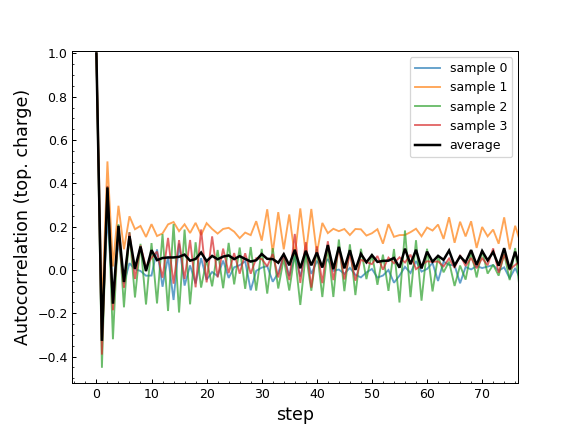

Saving figure to ../../gauge_logs_graph/run_60/figures/topological_charge_autocorr_fn.pdf.


In [84]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

<IPython.core.display.Javascript object>


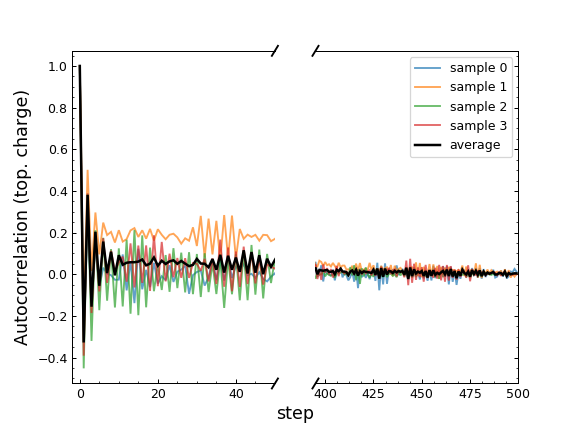

In [95]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

<IPython.core.display.Javascript object>


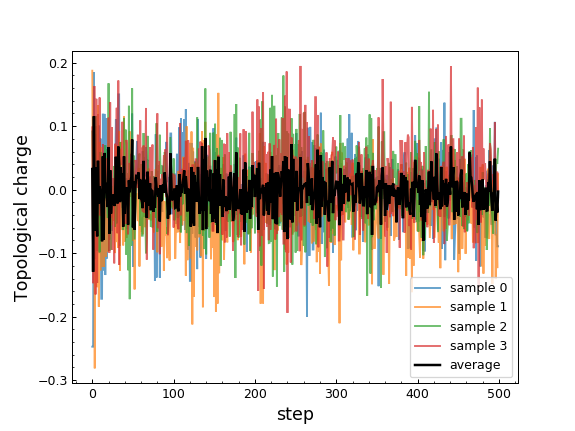

In [85]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge')

<IPython.core.display.Javascript object>


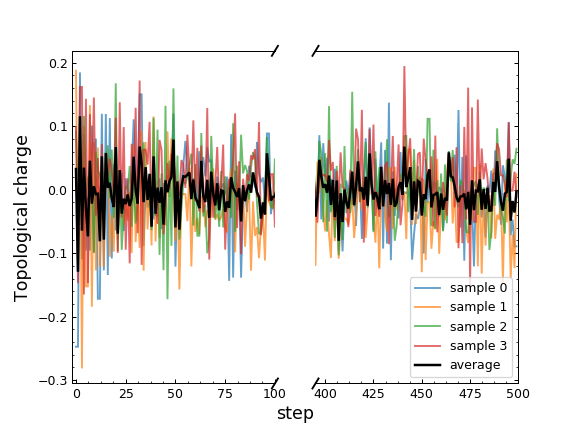

In [94]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(395, 500),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [87]:
from lattice.gauge_lattice import u1_plaq_exact

<IPython.core.display.Javascript object>


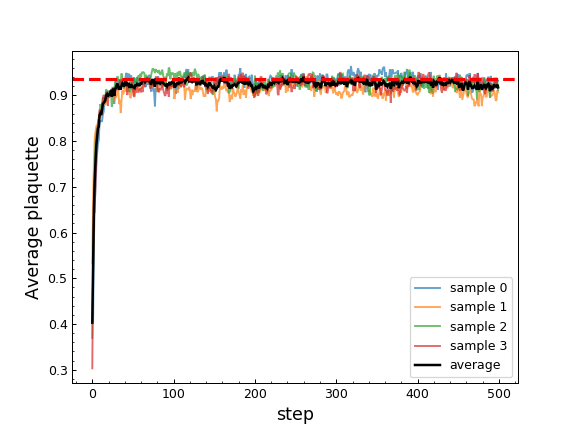

In [91]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

<IPython.core.display.Javascript object>


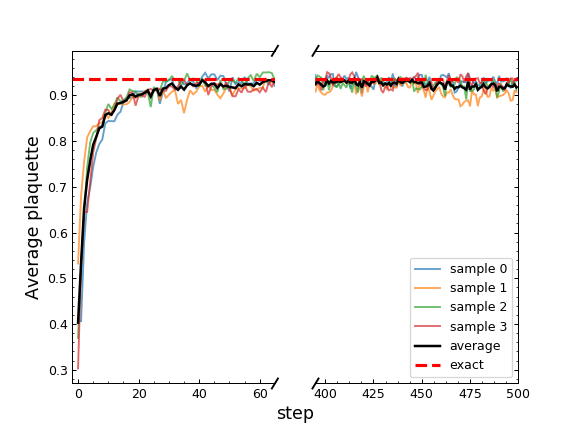

In [92]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(395, 500),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


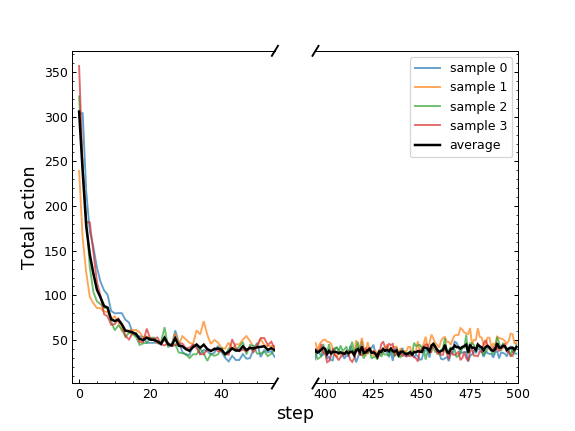

In [90]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(395, 500),
                                 output_file=out_file)

In [75]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

<IPython.core.display.Javascript object>


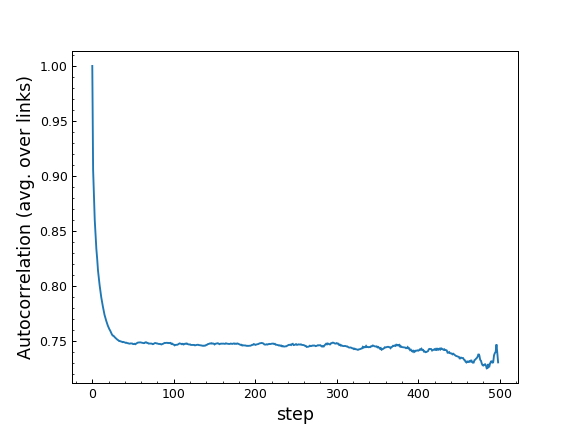

Text(0.5,0,'step')

Text(0,0.5,'Autocorrelation (avg. over links)')

In [76]:
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

## Compare Sample Autocorrelation across runs

In [132]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [137]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [143]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [152]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

(500,)

<IPython.core.display.Javascript object>


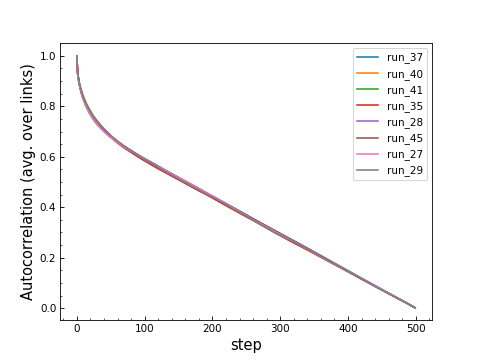

In [162]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [1]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

NameError: name 'plt' is not defined

### Incorrect

<IPython.core.display.Javascript object>


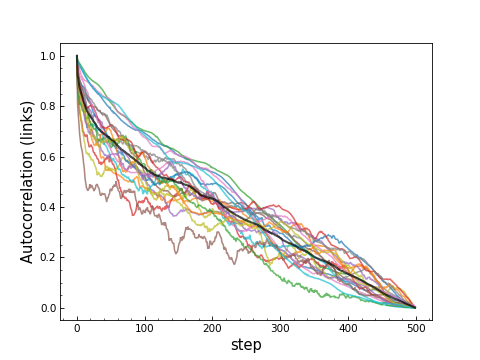

Saving figure to ../../gauge_logs_graph/run_40/figures/samples_acl_spectrum.pdf.


In [19]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

<IPython.core.display.Javascript object>


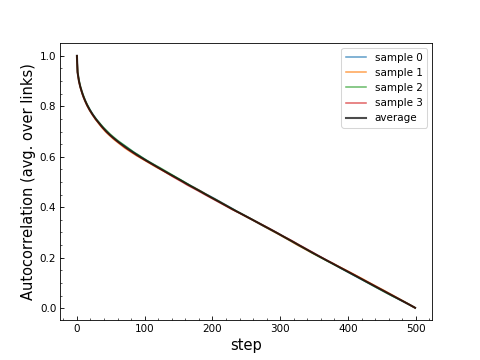

Saving figure to ../../gauge_logs_graph/run_40/figures/samples_acl_spectrum_avg.pdf.


In [20]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [92]:
tf.InteractiveSession.close

<function tensorflow.python.client.session.InteractiveSession.close(self)>

In [105]:
tf.Session().close()

In [90]:
#sess = tf.InteractiveSession()

/Users/saforem2/Library/Python/3.6/lib/python/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [106]:
tf.reset_default_graph()

In [107]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [108]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [109]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [110]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [111]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [112]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [113]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

ValueError: Fetch argument <tf.Operation 'make_initializer' type=MakeIterator> cannot be interpreted as a Tensor. (Operation name: "make_initializer"
op: "MakeIterator"
input: "MapDataset"
input: "IteratorV2"
device: "/device:CPU:0"
attr {
  key: "_class"
  value {
    list {
      s: "loc:@IteratorV2"
    }
  }
}
 is not an element of this graph.)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [99]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [100]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [102]:
dataset.output_shapes

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(2)])

In [104]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [103]:
dataset.apply(dynamics.apply_transition)

TypeError: Failed to convert object of type <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> to Tensor. Contents: <BatchDataset shapes: (?, 8, 8, 2), types: tf.float32>. Consider casting elements to a supported type.

In [85]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [76]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [51]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [52]:
dataset

<TensorDataset shapes: (2, 8, 8, 2), types: tf.float32>

In [41]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

TypeError: Failed to convert object of type <class 'tensorflow.python.data.ops.dataset_ops.TensorDataset'> to Tensor. Contents: <TensorDataset shapes: (2, 8, 8, 2), types: tf.float32>. Consider casting elements to a supported type.

In [53]:
iterator = dataset.make_initializable_iterator()

In [54]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.

In [55]:
next_element = iterator.get_next()

In [56]:
result = dynamics.apply_transition(next_element)

In [58]:
sess.run(result)

ValueError: Fetch argument <tf.Tensor 'add_6260:0' shape=(2, 8, 8, 2) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("add_6260:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})